In [45]:
# Import libraries

import pandas as pd
import numpy as np

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier,LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification
from sklearn.metrics import roc_auc_score

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")

In [46]:
np.random.seed(24)

In [47]:
def load_data():
    
    df = pd.read_csv("./kdd2004.csv")
    df["target"] = df["target"].map({-1:0,1:1})
    
    return df

It corresponds to the process of reducing the number of samples from the majority class until the balacing ratio is one (number of observation of the majority is the same as the minority).

Balacing ratio(X) =  X(Minority) / X(Majority)

Under-sampling can be random, or we remove the noisy observations, retains the observations inside a boundary or both the formers.

# Random Under-Sampling

Random Under-Sampling extract observations from the majority class until a certain balanced ratio is reached.

This approach is good in a way that it allows the algorithms to focus on both classes but it might remove important information for the majority class hence makes it harder for the algorithm to learn patterns that are useful to differenciate the two classes.


In [48]:
from imblearn.under_sampling import RandomUnderSampler

In [49]:
def make_class(sep):
    """Will create classes with different degrees of separateness."""

    X, y = make_classification(n_samples=1000,
                               n_features=2,
                               n_redundant=0,
                               n_classes=2,
                               n_clusters_per_class=1,
                               # The proportions of samples assigned to each class
                               weights=[0.99],
                               # How seperate the classes are
                               class_sep=sep,  
                               random_state=24,
                               )
    X = pd.DataFrame(X, columns=["varA", "varB"])

    y = pd.Series(y)

    return X, y

0    987
1     13
dtype: int64


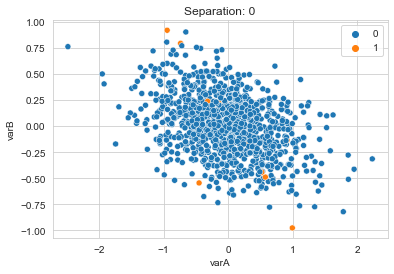

0    987
1     13
dtype: int64


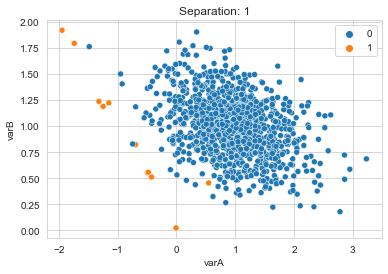

0    987
1     13
dtype: int64


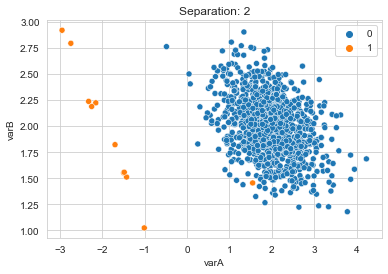

In [50]:
for sep in [0, 1, 2]:

    X, y = make_class(sep=sep)

    print(y.value_counts())

    sns.scatterplot(data=X, x="varA", y="varB", hue=y)
    
    plt.title(f"Separation: {sep}")
    plt.show()

In [51]:
X, y = make_class(sep=2)

rus = RandomUnderSampler(sampling_strategy='auto',
                         random_state=24,
                         replacement=False, # No replacement
                         )

X_resampled,y_resampled = rus.fit_resample(X,y)

In [52]:
X.shape,y.shape

((1000, 2), (1000,))

In [53]:
X_resampled.shape,y_resampled.shape

((26, 2), (26,))

In [54]:
y_resampled.value_counts()

0    13
1    13
dtype: int64

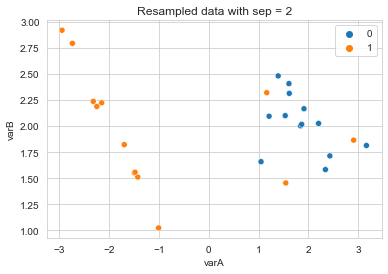

In [55]:
sns.scatterplot(data=X_resampled, x="varA", y="varB", hue=y_resampled)

plt.title(f"Resampled data with sep = 2")
plt.show()

In [56]:
df = load_data()

In [57]:
rus = RandomUnderSampler(sampling_strategy='auto',
                         random_state=24,
                         replacement=False, # No replacement
                         )

X_resampled,y_resampled = rus.fit_resample(df.drop(labels=["target"],axis=1),df["target"])

In [58]:
df.shape

(145751, 75)

In [59]:
X_resampled.shape,y_resampled.shape

((2592, 74), (2592,))

In [60]:
print(f"Before resampling:")
print(f"{df['target'].value_counts()}")
print(f"After resampling:")
print(f"{y_resampled.value_counts()}")

Before resampling:
0    144455
1      1296
Name: target, dtype: int64
After resampling:
0    1296
1    1296
Name: target, dtype: int64


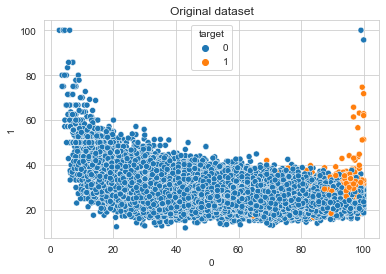

In [61]:
sns.scatterplot(data=df, x="0", y="1", hue="target")

plt.title(f"Original dataset")
plt.show()

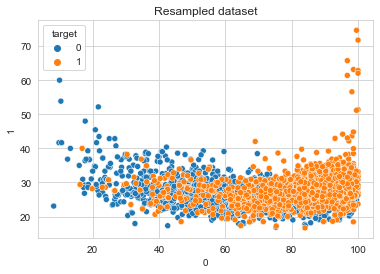

In [62]:
sns.scatterplot(data=X_resampled, x="0", y="1", hue=y_resampled)

plt.title(f"Resampled dataset")
plt.show()

In [63]:
def run_rf(X_train,X_test,y_train,y_test):
    
    rf = RandomForestClassifier(n_jobs=-1, n_estimators=200,max_depth=4)
    rf.fit(X_train,y_train)
    
    y_pred = rf.predict_proba(X_test)[:,1]
    
    print(f"ROC-AUC for the train set: {roc_auc_score(y_train,rf.predict_proba(X_train)[:,1])}")
    print(f"ROC-AUC for the test set: {roc_auc_score(y_test,y_pred)}")

In [64]:
X_train, X_test, y_train, y_test = train_test_split(df.drop(labels=["target"],axis=1),df["target"],test_size=0.33, random_state=24)

In [65]:
run_rf(X_train, X_test, y_train, y_test)

ROC-AUC for the train set: 0.9761414267359368
ROC-AUC for the test set: 0.9640441514681941


In [66]:
X_train_resampled, X_test_resampled, y_train_resampled, y_test_resampled = train_test_split(X_resampled,y_resampled,test_size=0.33, random_state=24)

In [67]:
run_rf(X_train_resampled, X_test_resampled, y_train_resampled, y_test_resampled)

ROC-AUC for the train set: 0.9945462026492528
ROC-AUC for the test set: 0.9833005786657932


There's an increase in performance!

In [68]:
rus = RandomUnderSampler(sampling_strategy='auto',
                         random_state=24,
                         replacement=True, # replacement
                         )

X_resampled,y_resampled = rus.fit_resample(df.drop(labels=["target"],axis=1),df["target"])

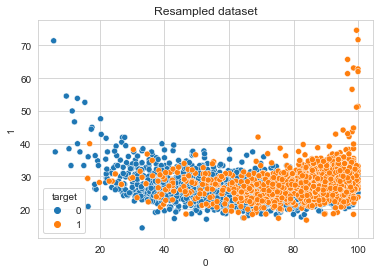

In [69]:
sns.scatterplot(data=X_resampled, x="0", y="1", hue=y_resampled)

plt.title(f"Resampled dataset")
plt.show()

In [70]:
X_train_resampled, X_test_resampled, y_train_resampled, y_test_resampled = train_test_split(X_resampled,y_resampled,test_size=0.33, random_state=24)

In [71]:
run_rf(X_train_resampled, X_test_resampled, y_train_resampled, y_test_resampled)

ROC-AUC for the train set: 0.9948501499827453
ROC-AUC for the test set: 0.9842668413582267


Slightly better model with replacement...

# Condensed Nearest Neighbours 

Extract observations at the boudary between the two, or more, classes.

It's a cleaning method that will change the final shape of the dataset, and the boundary of the classes matters.

It works as follow:
* Separate the minority class to the majority class.
* Add at random one instance of the majority class to the minority class.
* Train a 1-KNN algorithm.
* Use this KNN to make a prediction on one instance at a time on the majority class. If the instance belongs to the majority class, we can ignore this observation. If the prediction doesn't match the class, then we pass this observation to the minority group.
* After having one more observation, we train again a 1-KNN of the minority class + two observation from the majority class.
* Repeat step 4-5 until we have examined all the observations from the majority class and decided if they do belong in the dataset or not.

This dataset will be used to train the algorithm. It focuses on harder to differenciate observations between the two classes, but will introduce also noise in the dataset.

For the multi-class undersampling, it uses a One vs the Rest strategy.

In [72]:
from imblearn.under_sampling import CondensedNearestNeighbour

In [73]:
cnn = CondensedNearestNeighbour(sampling_strategy='auto',
                                random_state=24,
                                n_neighbors=None,
                                n_seeds_S=1,
                                n_jobs=-1,
                                )

In [74]:
X, y = make_class(sep=2)

X_resampled,y_resampled = cnn.fit_resample(X,y)

In [75]:
X.shape,y.shape,X_resampled.shape,y_resampled.shape

((1000, 2), (1000,), (38, 2), (38,))

In [76]:
y.value_counts(),y_resampled.value_counts()

(0    987
 1     13
 dtype: int64,
 0    25
 1    13
 dtype: int64)

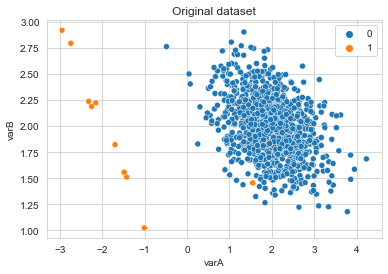

In [77]:
sns.scatterplot(data=X, x="varA", y="varB", hue=y)

plt.title(f"Original dataset")
plt.show()

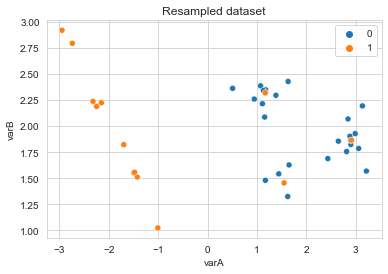

In [78]:
sns.scatterplot(data=X_resampled, x="varA", y="varB", hue=y_resampled)

plt.title(f"Resampled dataset")
plt.show()

The remaining points from the majority class are the points that are most likely to be misclassified. 

In [79]:
df = df.sample(frac=1).reset_index(drop=True)

In [80]:
X_resampled,y_resampled = cnn.fit_resample(df.drop(labels=["target"],axis=1)[:10000],df["target"][:10000])

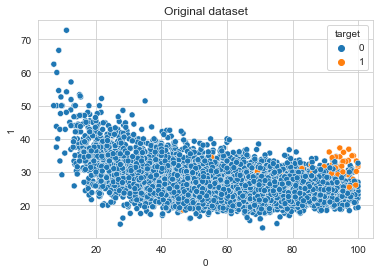

In [81]:
sns.scatterplot(data=df.drop(labels=["target"],axis=1)[:10000], x="0", y="1", hue=df["target"][:10000])

plt.title(f"Original dataset")
plt.show()

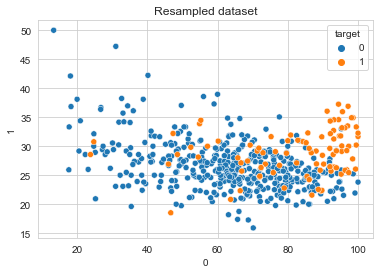

In [82]:
sns.scatterplot(data=X_resampled, x="0", y="1", hue=y_resampled)

plt.title(f"Resampled dataset")
plt.show()

In [83]:
X_train, X_test, y_train, y_test = train_test_split(df.drop(
    labels=["target"], axis=1)[:10000], df["target"][:10000], test_size=0.33, random_state=24)

In [84]:
run_rf(X_train, X_test, y_train, y_test)

ROC-AUC for the train set: 0.9960667670682731
ROC-AUC for the test set: 0.9516561389839627


In [85]:
X_train_resampled, X_test_resampled, y_train_resampled, y_test_resampled = train_test_split(
    X_resampled, y_resampled, test_size=0.33, random_state=24)

In [86]:
run_rf(X_train_resampled, X_test_resampled,
       y_train_resampled, y_test_resampled)

ROC-AUC for the train set: 0.9995226160639694
ROC-AUC for the test set: 0.9341787439613526


# Tomek links

If two samples are nearest neighbours and from two different classes, therefore they are tomek links.

It is a cleaning method that will remove samples from the dataset where the boundary matters.

We can choose to keep only the minority class of the tomek links by using sample_strategy="auto" or we remove all the tomek links by using sample_strategy="all".

This method removes noise hence improving the performance of the model but on the downside, it might make the model missclassified the hard cases to classify.

For the multi-class, it uses One vs Rest approach.

In [89]:
from imblearn.under_sampling import TomekLinks

In [90]:
tl = TomekLinks(sampling_strategy='auto', n_jobs=-1)

In [91]:
X, y = make_class(sep=2)

X_resampled,y_resampled = tl.fit_resample(X,y)

In [92]:
X.shape,y.shape,X_resampled.shape,y_resampled.shape

((1000, 2), (1000,), (998, 2), (998,))

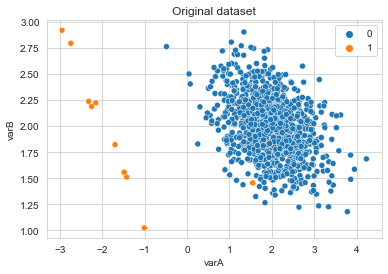

In [93]:
sns.scatterplot(data=X, x="varA", y="varB", hue=y)

plt.title(f"Original dataset")
plt.show()

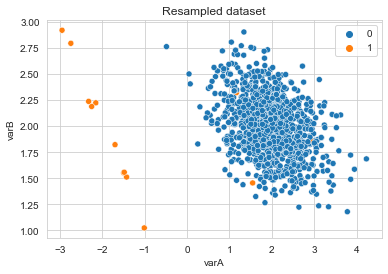

In [94]:
sns.scatterplot(data=X_resampled, x="varA", y="varB", hue=y_resampled)

plt.title(f"Resampled dataset")
plt.show()

In [95]:
X_resampled,y_resampled = tl.fit_resample(df.drop(labels=["target"],axis=1),df["target"])

In [96]:
df.shape,X_resampled.shape

((145751, 75), (145629, 74))

In [97]:
print(f"Number of observations removed: {df.shape[0] - X_resampled.shape[0]}")

Number of observations removed: 122


In [98]:
X_train, X_test, y_train, y_test = train_test_split(df.drop(
    labels=["target"], axis=1), df["target"], test_size=0.33, random_state=24)

In [99]:
run_rf(X_train, X_test, y_train, y_test)

ROC-AUC for the train set: 0.9728938337109407
ROC-AUC for the test set: 0.976026714631358


In [100]:
X_train_resampled, X_test_resampled, y_train_resampled, y_test_resampled = train_test_split(
    X_resampled, y_resampled, test_size=0.33, random_state=24)

In [101]:
run_rf(X_train_resampled, X_test_resampled, y_train_resampled, y_test_resampled)

ROC-AUC for the train set: 0.9792402728536967
ROC-AUC for the test set: 0.973195881160236


Not so much improvement...

# One Sided Selection

This method combines both Condensed Nearest Neighbours and Tomek Links.

First it selects instances at the boundary of the class with a CNN then remove the tomek links.

It claims to focus only on harder cases by selecting those at the boundary, while removing noise at the boundary with tomek links.

For multi-class, it uses the One vs Rest method.

In [102]:
from imblearn.under_sampling import OneSidedSelection

In [103]:
oss = OneSidedSelection(sampling_strategy='auto',
                        random_state=24,
                        n_neighbors=None,
                        n_seeds_S=1,
                        n_jobs=-1,
                        )

In [104]:
X,y = make_class(sep=2)

In [105]:
X_resampled,y_resampled = oss.fit_resample(X,y)

In [106]:
X.shape,X_resampled.shape

((1000, 2), (684, 2))

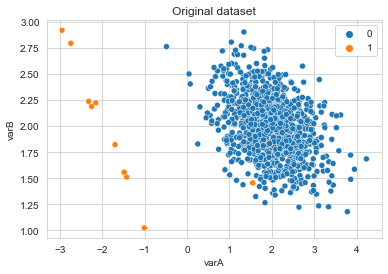

In [107]:
sns.scatterplot(data=X, x="varA", y="varB", hue=y)

plt.title(f"Original dataset")
plt.show()

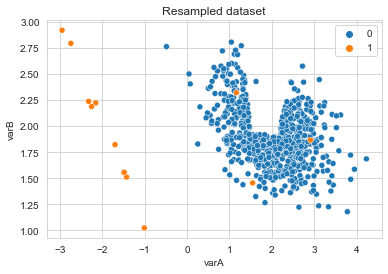

In [108]:
sns.scatterplot(data=X_resampled, x="varA", y="varB", hue=y_resampled)

plt.title(f"Resampled dataset")
plt.show()

In [109]:
X_resampled,y_resampled = oss.fit_resample(df.drop(labels=["target"],axis=1),df["target"])

In [110]:
df.shape,X_resampled.shape

((145751, 75), (145484, 74))

In [111]:
print(f"Number of observations removed: {df.shape[0] - X_resampled.shape[0]}")

Number of observations removed: 267


More observation removed than with the tomek links.

In [112]:
X_train, X_test, y_train, y_test = train_test_split(df.drop(
    labels=["target"], axis=1), df["target"], test_size=0.33, random_state=24)

In [113]:
run_rf(X_train, X_test, y_train, y_test)

ROC-AUC for the train set: 0.9688406496771247
ROC-AUC for the test set: 0.9685909515098083


In [114]:
X_train_resampled, X_test_resampled, y_train_resampled, y_test_resampled = train_test_split(
    X_resampled, y_resampled, test_size=0.33, random_state=24)

In [115]:
run_rf(X_train_resampled, X_test_resampled, y_train_resampled, y_test_resampled)

ROC-AUC for the train set: 0.975200434063649
ROC-AUC for the test set: 0.9714968630864829


There is an improvement on the model's performance (less overfitting).

# Edited Nearest Neighbours

This method removes samples which neighbours disagree on the class and look at each 3 neighbours that the observations is being evaluating.

It is a cleaning under-sampling method and removes the harder cases to class.

It works as follow:
* Train 3 KNN
* Finds each observation's 3 neighbours
* Decide wether or not to keep the observation based on the neighbours agreement with its class:
    * All neighbours agree
    * Most neighbours agree
    * 1 pass over the data
    
For multi-class classification, this algorithm uses One vs Rest method.

In practice, samples from the majority classes that are too close to the minority class are removed.

In [116]:
from imblearn.under_sampling import EditedNearestNeighbours

In [117]:
# If 'all', all neighbours will have to agree with the samples of interest to not be excluded.
# If 'mode', the majority vote of the neighbours will be used in order to exclude a sample.
ENN = EditedNearestNeighbours(sampling_strategy='auto',
                              n_neighbors=3,
                              kind_sel='all',
                              n_jobs=-1,
                              )

In [118]:
X,y = make_class(sep=2)

In [119]:
X_resampled,y_resampled = ENN.fit_resample(X,y)

In [120]:
X.shape,X_resampled.shape

((1000, 2), (990, 2))

Removed 10 observations...

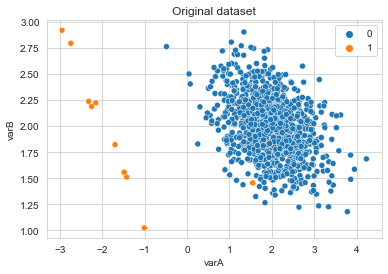

In [121]:
sns.scatterplot(data=X, x="varA", y="varB", hue=y)

plt.title(f"Original dataset")
plt.show()

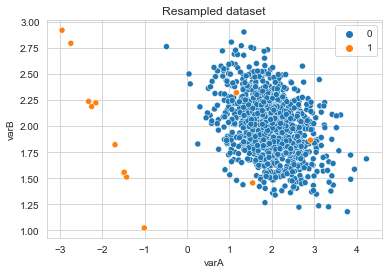

In [122]:
sns.scatterplot(data=X_resampled, x="varA", y="varB", hue=y_resampled)

plt.title(f"Resampled dataset")
plt.show()

In [123]:
X_resampled,y_resampled = ENN.fit_resample(df.drop(labels=["target"],axis=1),df["target"])

In [124]:
df.shape,X_resampled.shape

((145751, 75), (144643, 74))

In [125]:
print(f"Number of observations removed: {df.shape[0] - X_resampled.shape[0]}")

Number of observations removed: 1108


In [126]:
X_train, X_test, y_train, y_test = train_test_split(df.drop(
    labels=["target"], axis=1), df["target"], test_size=0.33, random_state=24)

In [127]:
run_rf(X_train, X_test, y_train, y_test)

ROC-AUC for the train set: 0.9707110503518891
ROC-AUC for the test set: 0.968980792654343


In [128]:
X_train_resampled, X_test_resampled, y_train_resampled, y_test_resampled = train_test_split(
    X_resampled, y_resampled, test_size=0.33, random_state=24)

In [129]:
run_rf(X_train_resampled, X_test_resampled, y_train_resampled, y_test_resampled)

ROC-AUC for the train set: 0.9747246944390513
ROC-AUC for the test set: 0.9718789283896484


Not so much improvement...

# Repeted Edited Nearest Neighbours

This method removes samples which neighbours disagree on the class and look at each 3 neighbours that the observations is being evaluating.

It is a cleaning under-sampling method and removes the harder cases to class.

It works as follow:
* Train 3 KNN
* Finds each observation's 3 neighbours
* Decide wether or not to keep the observation based on the neighbours agreement with its class:
    * All neighbours agree
    * Most neighbours agree
    * 1 pass over the data
* Repeats
    * Until no more observations are removed
    * A maximum number of cycles is reached

This method removes more observation than the Edited Nearest Neighbours with various passes over the dataset and the same number of neighbours.
    
For multi-class classification, this algorithm uses One vs Rest method.

In practice, samples from the majority classes that are too close to the minority class are removed.

In [130]:
from imblearn.under_sampling import RepeatedEditedNearestNeighbours

In [131]:
X, y = make_class(sep=2)

renn = RepeatedEditedNearestNeighbours(sampling_strategy='auto',
                                       n_neighbors=3,
                                       max_iter=100,
                                       kind_sel='all',
                                       n_jobs=-1,
                                       )

X_resampled,y_resampled = renn.fit_resample(X,y)

In [132]:
X.shape,X_resampled.shape

((1000, 2), (987, 2))

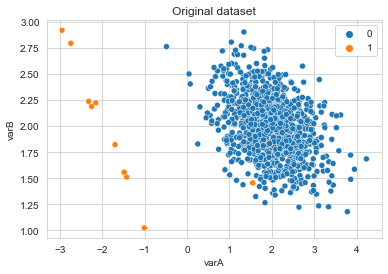

In [133]:
sns.scatterplot(data=X, x="varA", y="varB", hue=y)

plt.title(f"Original dataset")
plt.show()

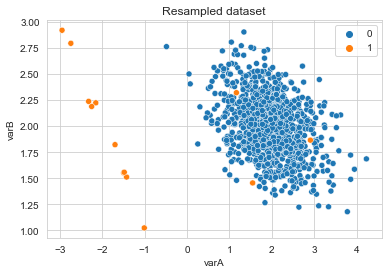

In [134]:
sns.scatterplot(data=X_resampled, x="varA", y="varB", hue=y_resampled)

plt.title(f"Resampled dataset")
plt.show()

In [135]:
X_resampled,y_resampled = renn.fit_resample(df.drop(labels=["target"],axis=1),df["target"])

In [136]:
df.shape,X_resampled.shape

((145751, 75), (144535, 74))

In [137]:
print(f"Number of observations removed: {df.shape[0] - X_resampled.shape[0]}")

Number of observations removed: 1216


In [138]:
X_train, X_test, y_train, y_test = train_test_split(df.drop(
    labels=["target"], axis=1), df["target"], test_size=0.33, random_state=24)

In [139]:
run_rf(X_train, X_test, y_train, y_test)

ROC-AUC for the train set: 0.9756820121706089
ROC-AUC for the test set: 0.979660061673391


In [140]:
X_train_resampled, X_test_resampled, y_train_resampled, y_test_resampled = train_test_split(
    X_resampled, y_resampled, test_size=0.33, random_state=24)

In [141]:
run_rf(X_train_resampled, X_test_resampled, y_train_resampled, y_test_resampled)

ROC-AUC for the train set: 0.9733943332569229
ROC-AUC for the test set: 0.9698172143919869


Little improvement (less overfitting) from the model.

# All KNN

This method removes samples which neighbours disagree on the class and look at each 3 neighbours that the observations is being evaluating.

It is a cleaning under-sampling method and removes the harder cases to class.

It works as follow:
* Train 3 KNN
* Finds each observation's 3 neighbours
* Decide wether or not to keep the observation based on the neighbours agreement with its class:
    * All neighbours agree
    * Most neighbours agree
    * 1 pass over the data
* Repeats by addind 1 to the KNN
    * Until no more observations are removed
    * A maximum number of cycles is reached

This method removes more observation than the Edited Nearest Neighbours with various passes over the dataset and the same number of neighbours, and the successive KNNs have more and more neighbours making it more stringent with more observations needed to agree on a specific class.
    
For multi-class classification, this algorithm uses One vs Rest method.

In practice, samples from the majority classes that are too close to the minority class are removed.

In [142]:
from imblearn.under_sampling import AllKNN

In [143]:
X, y = make_class(sep=2)

allknn = AllKNN(sampling_strategy='auto',
              n_neighbors=3, # The number of neighbours with start with.
              kind_sel='all', 
              n_jobs=-1,
              )

X_resampled, y_resampled = allknn.fit_resample(X, y)

In [144]:
X.shape,X_resampled.shape

((1000, 2), (987, 2))

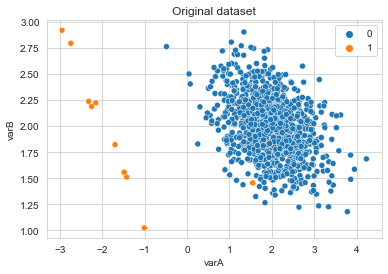

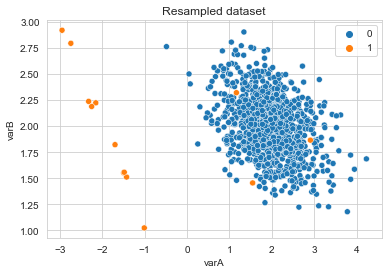

In [145]:
sns.scatterplot(data=X, x="varA", y="varB", hue=y)

plt.title(f"Original dataset")
plt.show()

sns.scatterplot(data=X_resampled, x="varA", y="varB", hue=y_resampled)

plt.title(f"Resampled dataset")
plt.show()

In [146]:
X_resampled,y_resampled = allknn.fit_resample(df.drop(labels=["target"],axis=1),df["target"])

In [147]:
df.shape,X_resampled.shape

((145751, 75), (144578, 74))

In [148]:
print(f"Number of observations removed: {df.shape[0] - X_resampled.shape[0]}")

Number of observations removed: 1173


In [149]:
X_train, X_test, y_train, y_test = train_test_split(df.drop(
    labels=["target"], axis=1), df["target"], test_size=0.33, random_state=24)

In [150]:
run_rf(X_train, X_test, y_train, y_test)

ROC-AUC for the train set: 0.9712525093166713
ROC-AUC for the test set: 0.9722452998462892


In [151]:
X_train_resampled, X_test_resampled, y_train_resampled, y_test_resampled = train_test_split(
    X_resampled, y_resampled, test_size=0.33, random_state=24)

In [152]:
run_rf(X_train_resampled, X_test_resampled, y_train_resampled, y_test_resampled)

ROC-AUC for the train set: 0.972817171319106
ROC-AUC for the test set: 0.972385873494849


No improvement...

# Neighbourhood Cleaning Rules

This method combines ENN + 3KNN only on neighbours of the minority class.

It is a cleaning under-sampling method and removes the harder cases to class.

It works as follow:
* Remove noisy observation from the majority class using a ENN with a 3KNN
* Remove observation from the majority class close to the boundary with a 1KNN
* Train 3 KNN on the whole dataset
* Finds each observation's 3 neighbours on the majority class
* Decide wether or not to keep the observation based on the neighbours agreement with its class:
    * All neighbours agree
    * Most neighbours agree
    * 1 pass over the data
* Train a 1KNN and remove observation from the majority class that are missclassified by the 1KNN.

Only removes neighbour if neighbour's proportion class is at least half of the observation of the minority class. This is done to avoid to remove other classes with fewer observation.

For multi-class classification, this algorithm uses One vs Rest method.

In practice, samples from the majority classes that are too close to the minority class are removed.

In [153]:
from imblearn.under_sampling import NeighbourhoodCleaningRule

In [154]:
X, y = make_class(sep=2)

ncr = NeighbourhoodCleaningRule(sampling_strategy='auto',
                                # The number of neighbours with start with.
                                n_neighbors=3,
                                kind_sel='all',
                                # Threshold used to whether consider a class or not during the cleaning after applying ENN.
                                threshold_cleaning=0.5,
                                n_jobs=-1,
                                )

X_resampled, y_resampled = ncr.fit_resample(X, y)

In [155]:
X.shape,X_resampled.shape

((1000, 2), (991, 2))

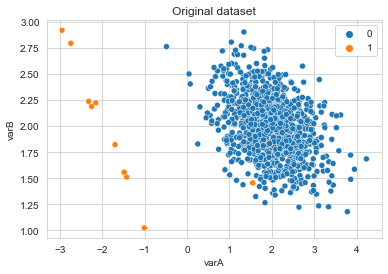

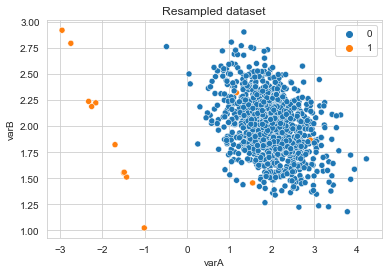

In [156]:
sns.scatterplot(data=X, x="varA", y="varB", hue=y)

plt.title(f"Original dataset")
plt.show()

sns.scatterplot(data=X_resampled, x="varA", y="varB", hue=y_resampled)

plt.title(f"Resampled dataset")
plt.show()

In [157]:
X_resampled,y_resampled = ncr.fit_resample(df.drop(labels=["target"],axis=1),df["target"])

In [158]:
df.shape,X_resampled.shape

((145751, 75), (143805, 74))

In [159]:
print(f"Number of observations removed: {df.shape[0] - X_resampled.shape[0]}")

Number of observations removed: 1946


In [160]:
X_train, X_test, y_train, y_test = train_test_split(df.drop(
    labels=["target"], axis=1), df["target"], test_size=0.33, random_state=24)

In [161]:
run_rf(X_train, X_test, y_train, y_test)

ROC-AUC for the train set: 0.9751724945520379
ROC-AUC for the test set: 0.9758312524078858


In [162]:
X_train_resampled, X_test_resampled, y_train_resampled, y_test_resampled = train_test_split(
    X_resampled, y_resampled, test_size=0.33, random_state=24)

In [163]:
run_rf(X_train_resampled, X_test_resampled, y_train_resampled, y_test_resampled)

ROC-AUC for the train set: 0.9770779778488683
ROC-AUC for the test set: 0.9668388148816253


No improvements...

# Near Miss

NearMiss is a fixed method that will return a final dataset with a number of observations being equal to two times the number of observation of the minority class, and it retains information closer to the minority class.

It was design to work with text where each word is a complex representation of words and tags.

3 different versions.

V1:
* Determine the mean distance to each k closest neighbour from X minority.
* Retains observations from X majority with the smallest average distance.

**Select observations closer to the closest minority class.**

V2:
* Determine the mean distance to each k furthest neighbour from X minority.
* Retains observations from X majority with the smallest average distance.

**Select observations closer to the farthest minority class.**


V3:
* Retains the 3 closest K from the minority -- > intermediare dataset.
* Then select X majority which average distance to X min is the largest.

**Select observations furthest to their nearest neighbours.**

For multi-class classification, it uses One vs Rest.

In [164]:
from imblearn.under_sampling import NearMiss

In [165]:
X, y = make_class(sep=2)

nm = NearMiss(sampling_strategy='auto',
              version=1, #version 1, 2 or 3
              n_neighbors=3,
              # parameter correspond to the number of neighbours selected
              # create the subset in which the selection will be performed
              n_neighbors_ver3=3,
              n_jobs=-1,
              )

X_resampled, y_resampled = nm.fit_resample(X, y)

In [166]:
X.shape,X_resampled.shape

((1000, 2), (26, 2))

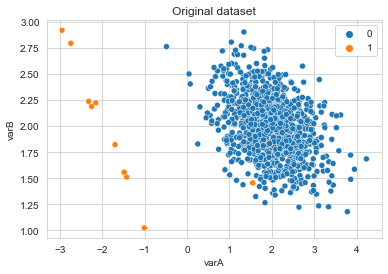

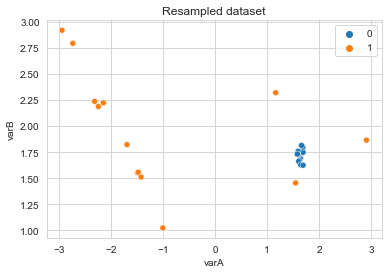

In [167]:
sns.scatterplot(data=X, x="varA", y="varB", hue=y)

plt.title(f"Original dataset")
plt.show()

sns.scatterplot(data=X_resampled, x="varA", y="varB", hue=y_resampled)

plt.title(f"Resampled dataset")
plt.show()

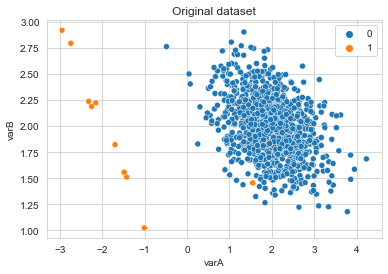

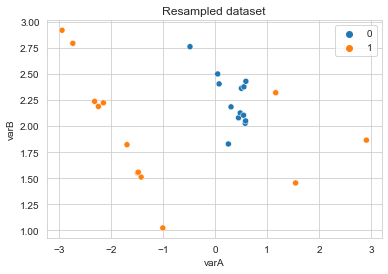

In [168]:
X, y = make_class(sep=2)

nm = NearMiss(sampling_strategy='auto',
              version=2, #version 1, 2 or 3
              n_neighbors=3,
              # parameter correspond to the number of neighbours selected
              # create the subset in which the selection will be performed
              n_neighbors_ver3=3,
              n_jobs=-1,
              )

X_resampled, y_resampled = nm.fit_resample(X, y)
X.shape,X_resampled.shape

sns.scatterplot(data=X, x="varA", y="varB", hue=y)

plt.title(f"Original dataset")
plt.show()

sns.scatterplot(data=X_resampled, x="varA", y="varB", hue=y_resampled)

plt.title(f"Resampled dataset")
plt.show()

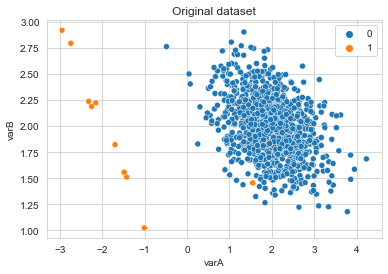

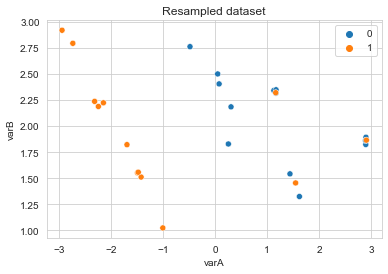

In [169]:
X, y = make_class(sep=2)

nm = NearMiss(sampling_strategy='auto',
              version=3, #version 1, 2 or 3
              n_neighbors=3,
              # parameter correspond to the number of neighbours selected
              # create the subset in which the selection will be performed
              n_neighbors_ver3=3,
              n_jobs=-1,
              )

X_resampled, y_resampled = nm.fit_resample(X, y)
X.shape,X_resampled.shape

sns.scatterplot(data=X, x="varA", y="varB", hue=y)

plt.title(f"Original dataset")
plt.show()

sns.scatterplot(data=X_resampled, x="varA", y="varB", hue=y_resampled)

plt.title(f"Resampled dataset")
plt.show()

In [170]:
X_resampled,y_resampled = nm.fit_resample(df.drop(labels=["target"],axis=1),df["target"])

In [171]:
df.shape,X_resampled.shape

((145751, 75), (2592, 74))

In [172]:
print(f"Number of observations removed: {df.shape[0] - X_resampled.shape[0]}")

Number of observations removed: 143159


In [173]:
X_train, X_test, b_train, y_test = train_test_split(df.drop(
    labels=["target"], axis=1), df["target"], test_size=0.33, random_state=24)

In [174]:
run_rf(X_train, X_test, y_train, y_test)

ROC-AUC for the train set: 0.9730268662409959
ROC-AUC for the test set: 0.9747930793914913


In [175]:
X_train_resampled, X_test_resampled, y_train_resampled, y_test_resampled = train_test_split(
    X_resampled, y_resampled, test_size=0.33, random_state=24)

In [176]:
run_rf(X_train_resampled, X_test_resampled, y_train_resampled, y_test_resampled)

ROC-AUC for the train set: 0.9851331262775078
ROC-AUC for the test set: 0.9789715034392401


Better performance!

# Insteance Hardness Threshold

The probability of an observation being miss-classified. The smaller the probability of a class, the higher the chance that this observation being miss-classified.

it works as follow:
* Train a classifier.
* Determine the probability of each observation of the majority class.
* Find the threshold (percentile = (1 - (nXmin / nXmaj) * 100).
* Select observations where probability > threshold.

In [177]:
from imblearn.under_sampling import InstanceHardnessThreshold

In [178]:
X, y = make_class(sep=2)

iht = InstanceHardnessThreshold(sampling_strategy='auto',
                               estimator=None, #Default will be RF
                               random_state=None,
                               cv=5,
                               n_jobs=-1,
                               )

X_resampled, y_resampled = iht.fit_resample(X, y)

In [179]:
X.shape,X_resampled.shape

((1000, 2), (943, 2))

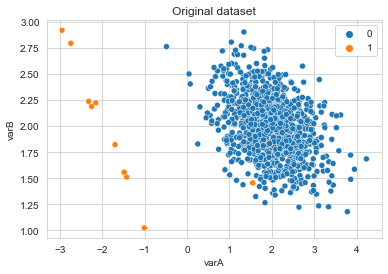

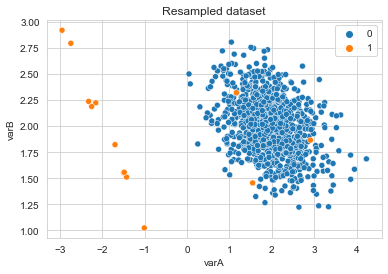

In [180]:
sns.scatterplot(data=X, x="varA", y="varB", hue=y)

plt.title(f"Original dataset")
plt.show()

sns.scatterplot(data=X_resampled, x="varA", y="varB", hue=y_resampled)

plt.title(f"Resampled dataset")
plt.show()

In [181]:
removed_obs = [0 if x in iht.sample_indices_ else 1 for x in X.index]

len(removed_obs),np.mean(removed_obs)

(1000, 0.057)

6.4% instances removed...

In [182]:
X_resampled,y_resampled = iht.fit_resample(df.drop(labels=["target"],axis=1),df["target"])

In [183]:
df.shape,X_resampled.shape

((145751, 75), (126511, 74))

In [184]:
print(f"Number of observations removed: {df.shape[0] - X_resampled.shape[0]}")

Number of observations removed: 19240


In [185]:
X_train, X_test, b_train, y_test = train_test_split(df.drop(
    labels=["target"], axis=1), df["target"], test_size=0.33, random_state=24)

In [186]:
run_rf(X_train, X_test, y_train, y_test)

ROC-AUC for the train set: 0.9727880751357374
ROC-AUC for the test set: 0.9757717446368652


In [187]:
X_train_resampled, X_test_resampled, y_train_resampled, y_test_resampled = train_test_split(
    X_resampled, y_resampled, test_size=0.33, random_state=24)

In [188]:
run_rf(X_train_resampled, X_test_resampled, y_train_resampled, y_test_resampled)

ROC-AUC for the train set: 0.9808335927152658
ROC-AUC for the test set: 0.9830205198607159


Improvements!

# Performance comparaison between the different techniques

To be filled...

In [189]:
# Importing the needed libraries
from collections import Counter

from sklearn.preprocessing import MinMaxScaler

from imblearn.datasets import fetch_datasets

In [190]:
undersampler_dict = {
    "RUS": RandomUnderSampler(sampling_strategy='auto',
                              random_state=24,
                              replacement=False,  # No replacement
                              ),
    "CNN": CondensedNearestNeighbour(sampling_strategy='auto',
                                     random_state=24,
                                     n_neighbors=None,
                                     n_seeds_S=1,
                                     n_jobs=-1,
                                     ),
    "TL": TomekLinks(sampling_strategy='auto', n_jobs=-1),
    "OSS": OneSidedSelection(sampling_strategy='auto',
                             random_state=24,
                             n_neighbors=None,
                             n_seeds_S=1,
                             n_jobs=-1,
                             ),
    "ENN": EditedNearestNeighbours(sampling_strategy='auto',
                                   n_neighbors=3,
                                   kind_sel='all',
                                   n_jobs=-1,
                                   ),
    "ALLKNN": AllKNN(sampling_strategy='auto',
                     # The number of neighbours with start with.
                     n_neighbors=3,
                     kind_sel='all',
                     n_jobs=-1,
                     ),
    "NCR": NeighbourhoodCleaningRule(sampling_strategy='auto',
                                     # The number of neighbours with start with.
                                     n_neighbors=3,
                                     kind_sel='all',
                                     # Threshold used to whether consider a class or not during the cleaning after applying ENN.
                                     threshold_cleaning=0.5,
                                     n_jobs=-1,
                                     ),
    "NM": NearMiss(sampling_strategy='auto',
                   version=1,  # version 1, 2 or 3
                   n_neighbors=3,
                   # parameter correspond to the number of neighbours selected
                   # create the subset in which the selection will be performed
                   n_neighbors_ver3=3,
                   n_jobs=-1,
                   ),
    "IHT": InstanceHardnessThreshold(sampling_strategy='auto',
                                     estimator=None,  # Default will be RF
                                     random_state=None,
                                     cv=5,
                                     n_jobs=-1,
                                     )
}

In [193]:
fetch_datasets().keys() #List of the datasets to work with

odict_keys(['ecoli', 'optical_digits', 'satimage', 'pen_digits', 'abalone', 'sick_euthyroid', 'spectrometer', 'car_eval_34', 'isolet', 'us_crime', 'yeast_ml8', 'scene', 'libras_move', 'thyroid_sick', 'coil_2000', 'arrhythmia', 'solar_flare_m0', 'oil', 'car_eval_4', 'wine_quality', 'letter_img', 'yeast_me2', 'webpage', 'ozone_level', 'mammography', 'protein_homo', 'abalone_19'])

In [194]:
datasets = [
    "car_eval_34",
    "ecoli",
    "car_eval_4",
    "wine_quality"
]

In [197]:
for dataset in datasets:
    print(f"Dataset name: {dataset}")
    print(Counter(fetch_datasets()[dataset].target))
    print("\n")

Dataset name: car_eval_34
Counter({-1: 1594, 1: 134})


Dataset name: ecoli
Counter({-1: 301, 1: 35})


Dataset name: car_eval_4
Counter({-1: 1663, 1: 65})


Dataset name: wine_quality
Counter({-1: 4715, 1: 183})




In [206]:
def run_rf(X_train,X_test,y_train,y_test):
    
    rf = RandomForestClassifier(n_jobs=-1, n_estimators=100,max_depth=3)
    rf.fit(X_train,y_train)
    
    y_pred = rf.predict_proba(X_test)[:,1]
    
    print(f"ROC-AUC for the train set: {roc_auc_score(y_train,rf.predict_proba(X_train)[:,1])}")
    print(f"ROC-AUC for the test set: {roc_auc_score(y_test,y_pred)}")
    
    return roc_auc_score(y_test,y_pred)

In [210]:
results_dic = {}
shape_dataset = {}

for dataset in datasets:

    print(dataset)
    print("\n")
    print("Results for the original dataset")
    
    # Dict to store the results
    results_dic[dataset] = {}
    shape_dataset[dataset] = {}

    # Load the dataset
    data = fetch_datasets()[dataset]

    # Train-Test Split
    X_train, X_test, y_train, y_test = train_test_split(
        data.data, data.target, test_size=0.33, random_state=24)

    # Scaler because of the KNN used by the undersampling methods
    scaler = MinMaxScaler()

    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    # Getting the performance for the original dataset
    roc = run_rf(X_train, X_test, y_train, y_test)
    
    results_dic[dataset]["full_data"] = roc
    shape_dataset[dataset]["full_data"] = len(X_train)

    # Trying all the undersampling methods
    for undersampler in undersampler_dict.keys():
        
        print(undersampler)
        
        # Fit transform with the undersampling method
        X_resampled, y_resampled = undersampler_dict[undersampler].fit_resample(
            X_train, y_train)

        # Getting the performance
        roc = run_rf(X_resampled, X_test, y_resampled, y_test)

        results_dic[dataset][undersampler] = roc
        shape_dataset[dataset][undersampler] = len(X_resampled)
        print("\n")

    print("\n")

car_eval_34


Results for the original dataset
ROC-AUC for the train set: 0.9807217033815737
ROC-AUC for the test set: 0.9806865464632455
RUS
ROC-AUC for the train set: 0.9922748191978962
ROC-AUC for the test set: 0.989493758668516


CNN
ROC-AUC for the train set: 0.9836567336567336
ROC-AUC for the test set: 0.9970180305131761


TL
ROC-AUC for the train set: 0.9814019003963138
ROC-AUC for the test set: 0.9829403606102636


OSS
ROC-AUC for the train set: 0.9779691287153973
ROC-AUC for the test set: 0.9787794729542302


ENN
ROC-AUC for the train set: 0.9861774831714711
ROC-AUC for the test set: 0.9742718446601941


ALLKNN
ROC-AUC for the train set: 0.9819696069696069
ROC-AUC for the test set: 0.979750346740638


NCR
ROC-AUC for the train set: 0.9857231533209188
ROC-AUC for the test set: 0.9866504854368933


NM
ROC-AUC for the train set: 0.9293228139381986
ROC-AUC for the test set: 0.9949722607489598


IHT
ROC-AUC for the train set: 0.9798951048951049
ROC-AUC for the test set: 0.992995839

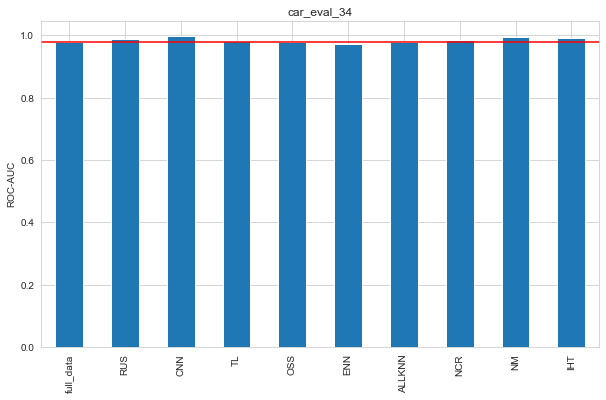

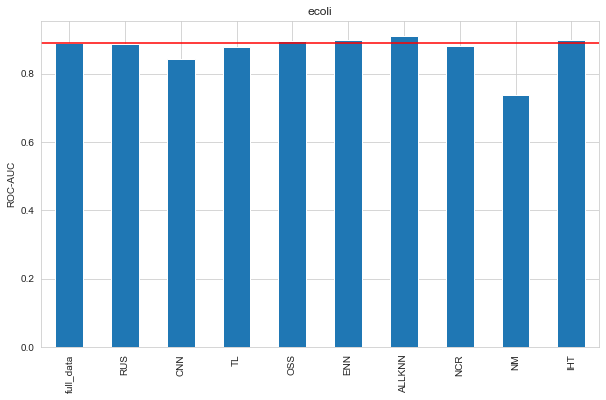

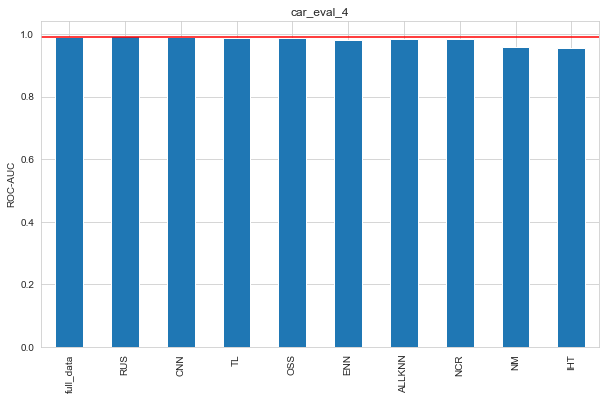

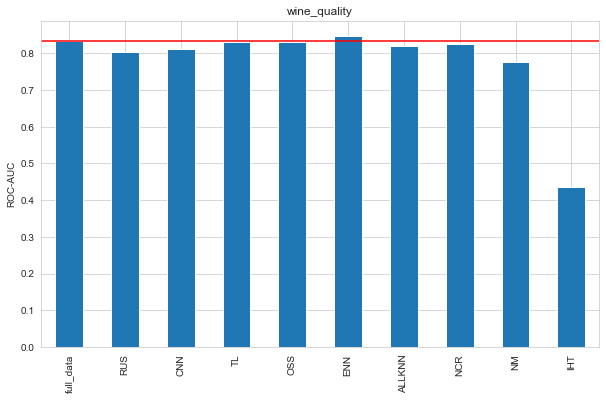

In [216]:
for dataset in datasets:
    plt.figure(figsize=(10,6))
    pd.Series(results_dic[dataset]).plot.bar()
    plt.title(dataset)
    plt.ylabel("ROC-AUC")
    plt.axhline(results_dic[dataset]["full_data"],color="r")
    plt.show()

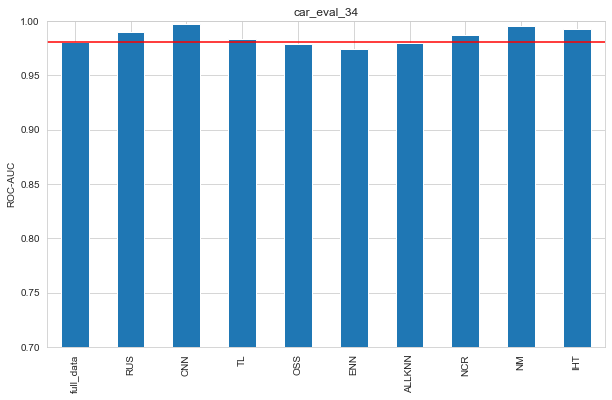

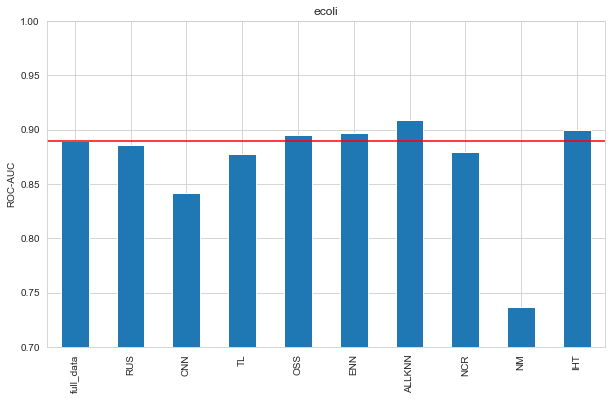

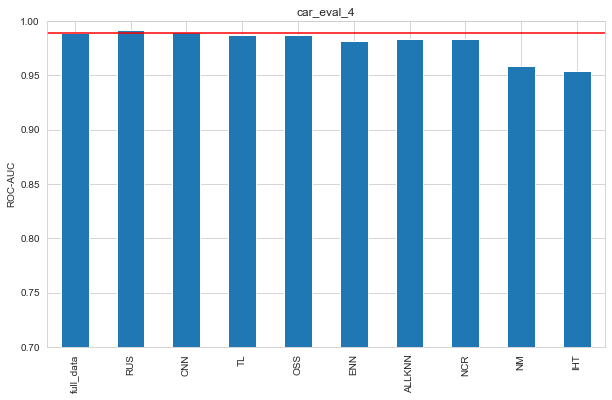

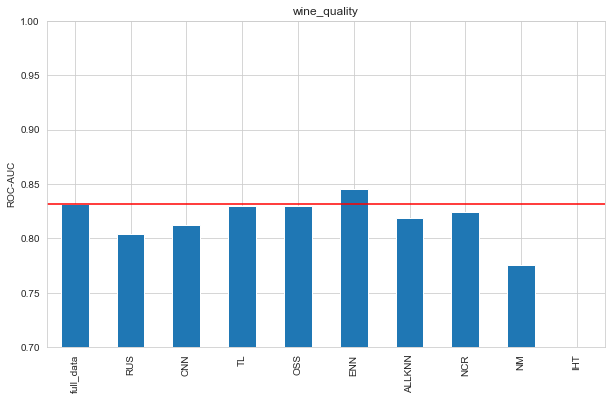

In [221]:
for dataset in datasets:
    plt.figure(figsize=(10,6))
    pd.Series(results_dic[dataset]).plot.bar()
    plt.ylim(0.7,1)
    plt.title(dataset)
    plt.ylabel("ROC-AUC")
    plt.axhline(results_dic[dataset]["full_data"],color="r")
    plt.show()

Different undersampling techniques work for different datasets...

# Sum-Up

**Random Under-Sampling:**
* Method of data exclusion: Random
* Final Dataset size : 2 times minority class
* Fixed vs Cleaned: Fixed
* UnderSampling-Criteria: Random

**Condensed Nearest Neighbours:**
* Method of data exclusion: Samples outside the boundary between the classes
* Final Dataset size : Varies
* Fixed vs Cleaned: Cleaning
* UnderSampling-Criteria: Keep Boundary observations

**Tomek Links:**
* Method of data exclusion: Samples are Tomek Links
* Final Dataset size : Varies
* Fixed vs Cleaned: Cleaning
* UnderSampling-Criteria: Remove noisy observation

**One Side Selection:**
* Method of data exclusion: CNN + Tomek links
* Final Dataset size : Varies
* Fixed vs Cleaned: Cleaning
* UnderSampling-Criteria: Both keep and remove boundary observations

**Edited Nearest Neighbours:**
* Method of data exclusion: Observation's class is different from that of its nearest neighbours
* Final Dataset size : Varies
* Fixed vs Cleaned: Cleaning
* UnderSampling-Criteria: Remove noisy observation

**Repeated Edited Nearest Neighbours:**
* Method of data exclusion: Repeat ENN mutiple times
* Final Dataset size : Varies
* Fixed vs Cleaned: Cleaning
* UnderSampling-Criteria: Remove noisy observation

**All KNN:**
* Method of data exclusion: Repeats ENN, plus 1 neighbour in each KNN iteration
* Final Dataset size : Varies
* Fixed vs Cleaned: Cleaning
* UnderSampling-Criteria: Remove noisy observation

**Neighbourhood Cleaning Rules:**
* Method of data exclusion: Combines ENN with a 1 KNN data exclusion criteria
* Final Dataset size : Varies
* Fixed vs Cleaned: Cleaning
* UnderSampling-Criteria: Remove noisy observation

**Near Miss:**
* Method of data exclusion: Selects samples closer to: 1) the closest minority class, 2) the furthest minority class, 3) furthest from its nearest neighbour
* Final Dataset size : Fixed
* Fixed vs Cleaned: 2 times minority class
* UnderSampling-Criteria: Keep boundary observations

**Near Miss:**
* Method of data exclusion: Probability by a certain classifier > a threshold
* Final Dataset size : Varies, at least 2 times minority class
* Fixed vs Cleaned: Fixed
* UnderSampling-Criteria: Remove noisy observations